In [1]:
#imports
import numpy as np
import pandas as pd
import scipy
import math
from decimal import Decimal

#loading libraries
import requests
import urllib.request
from flask import url_for

#performing GSEA
import gseapy as gp
from gseapy.gsea import GSEA
import blitzgsea as blitz
from maayanlab_bioinformatics.dge import limma_voom
from geode import chdir

#creating visualizations
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, HTML, IFrame

In [2]:
result_number = 5
result_criteria = 'pval'
augmentation = True
library_tab = 'Select an Enrichr Library'
library_filename = 'KEGG_2021_Human'
library_name = 'KEGG_2021_Human'
data_tab = 'Option 1'
ranked_filename = 'logFC_ranked_GSE70466.rnk'

In [3]:
#checks if inputs are valid
def checkInputs():
    if data_tab == 'Option 1':
        if library_filename == '' or ranked_filename == '':
            raise Exception('Please submit necessary materials for Option 1 to continue.')
        if ranked_filename.endswith('.rnk') == False:
            raise Exception('Please upload a RNK file (ends in .rnk).')
    else:
        if (library_filename == '' or expression_filename == '' or phenotype_filename == ''):
            raise Exception('Please submit necessary materials for Option 2 to continue.')
        if expression_filename.endswith('.gct') == False:
            raise Exception('Please upload a GCT file (ends in .gct).')
        if phenotype_filename.endswith('.cls') == False:
            raise Exception('Please upload a CLS file (ends in .cls).')
    if (library_tab == 'Upload' and library_filename.endswith('.gmt') == False):
        raise Exception('Please upload a GMT file (ends in .gmt).')

#performs GSEA
def gsea(signature, library):
    return blitz.gsea(signature, library, max_size=500)

In [4]:
#loads a preranked list and converts it to a dataframe for Option 1
#creates a ranked list with chosen ranking method and converts to dataframe for Option 2
def loadRanked():
    if data_tab == 'Option 1':
        values = pd.read_csv(ranked_filename, header=None, sep="\t")
        if len(values.index) < 5000:
            raise Exception('Current ranked gene list has less than 5000 genes. We expect all human coding genes to be in the list, which is around 20000.')
        values.sort_values(by=values.columns[1], ascending=False, inplace=True)
        values.reset_index(drop=True, inplace=True)
        values.columns = ['Gene', 'Rank']
        pos, neg = None, None
    elif data_tab == 'Option 2':
        neg, pos, classes = gp.parser.gsea_cls_parser(phenotype_filename)
        exp = pd.read_csv(expression_filename, skiprows=1, header=None, index_col=0, sep="\t")
        obj = GSEA(data=exp, gene_sets=library_filename, classes=classes)
        exp_df, classesDict = obj.load_data(classes)
        if ranking_method == 'cd':
            data = exp_df.to_numpy()
            sampleclass = [1 if s == neg else 2 if s == pos else 0 for s in classes]
            genes = exp_df.index.tolist()
            chdir_res = chdir(data=data, sampleclass=sampleclass, genes=genes)
            chdir_res = sorted(chdir_res, key=lambda x: x[0], reverse=True)
            chdir_res = {k:v for v,k in chdir_res}
            values = pd.Series(data=chdir_res)
        elif ranking_method == 'limma':
            neg_columns = [i for i in range(len(classes)) if classes[i] == neg]
            neg_df = exp_df.iloc[:,neg_columns]
            pos_columns = [i for i in range(len(classes)) if classes[i] == pos]
            pos_df = exp_df.iloc[:,pos_columns]
            limma_res = limma_voom.limma_voom_differential_expression(
                controls_mat=neg_df, cases_mat=pos_df, all_data_mat=exp_df)
            values = pd.Series(data=limma_res['logFC'], index=limma_res.index)
            values.sort_values(axis=0, ascending=False, inplace=True)
        else:
            values = gp.algorithm.ranking_metric(df=exp_df, pos=pos, neg=neg, 
            method=ranking_method, classes=classesDict, ascending=False)
        values = pd.DataFrame({'Gene':values.index, 'Rank':values.values})
    return values, pos, neg

In [6]:
#loads libraries
def downloadLibrary(name):
    urllib.request.urlretrieve(f'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName={name}', filename=f'{name}')
    if library_tab != 'Upload' and augmentation == True:
        urllib.request.urlretrieve(f'https://appyters.maayanlab.cloud/storage/GSEA_Appyter/{name}_augmented.gmt', filename=f'{name}_augmented')

def getLibraryData(library):
    data = dict()
    with open(library, 'r') as f:
        for line in f:
            splited = line.strip().split("\t")
            elements = splited[2:]
            if len(elements) > 0:
                # to upper case
                data[splited[0]] = [x.upper() for x in elements]
    return data

def loadLibrary(library):
    if library_tab == 'Select an Enrichr Library':
        downloadLibrary(library)
    library_data = getLibraryData(library)
    if len(library_data) < result_number:
        raise Exception('There cannot be less gene sets in the library than the number of gene sets displayed for the results.')
    if library_tab != 'Upload' and augmentation == True:
        augmented_data = getLibraryData(f'{library}_augmented')
    else:
        augmented_data = None
    return library_data, augmented_data

In [7]:
#loading all needed data
print('Checking inputs...')
checkInputs()
print('Loading data for plots...')
ranked, pheno1, pheno2 = loadRanked()
library_data, augmented_data = loadLibrary(library_filename)
print('Performing GSEA...')
result = blitz.gsea(ranked, library_data)
print('Data loaded successfully!')

Checking inputs...
Loading data for plots...
Performing GSEA...


Enrichment : 100%|██████████| 320/320 [00:00<00:00, 665.84it/s]

Data loaded successfully!


In [8]:
def validateNumber(num):
    num = round(num, 4)
    if abs(num) <= 0.001:
        num = '<0.001'
    elif abs(num) <= 0.01:
        num = '{:.2E}'.format(num)
    return num

def geneStringToList(string):
    return string.split(';')

#create a downloadable csv file of all the results
def create_download_link(df, title = "Download CSV file of all results", filename = "GSEA_Enrichment_Results_data.csv"):  
    csv = df.to_csv(filename, index = True)
    html = f'<a href="{filename}" target=_blank>{title}</a>'
    return HTML(f"<div style='font-size:1.25rem;'>{html}")

In [22]:
ranked

0          1
0         KLK3  11.853159
1      UGT2B17  11.553816
2       HMGCS2  11.009616
3       MAGEA3  10.890463
4        PTGFR  10.794927
...        ...        ...
14790    KRT17 -13.719688
14791     KRT5 -13.755405
14792     PLAU -13.756845
14793    KRT6A -13.848355
14794   FGFBP1 -14.541300

[14795 rows x 2 columns]

In [23]:
#organizes gsea results into sorted dataframe (for download)
result_df = result
result_df.index.name = 'gene set'
if result_criteria == 'pval':
    sorted_result_df = result_df.sort_values(by=['pval', 'fdr'], ascending=True)
elif result_criteria == 'fdr':
     sorted_result_df = result_df.sort_values(by=['fdr', 'pval'], ascending=True)
else:
    sorted_result_df = result_df.sort_values(by=result_criteria, ascending=False)

#sorted_result_df['genes'] = sorted_result_df['genes'].map(geneStringToList)
sorted_result_df['leading_edge'] = sorted_result_df['leading_edge'].map(geneStringToList)

#gets top gene sets' data (calculated statistics only) needed for the table display
top_result_df = sorted_result_df.copy(deep=True)
top_result_df.reset_index(inplace=True)
top_result_df = top_result_df.truncate(before=0, after=result_number-1)
top_result_df.set_index(keys='gene set', inplace=True)
top_result_df = top_result_df.drop(['leading_edge'], axis=1)
top_result_df = top_result_df.applymap(validateNumber)

#converts necessary dataframes to list
rankedGenes = ranked[0].tolist()
rankedCorrelation = ranked[1].tolist()
top = top_result_df.index.tolist()

In [27]:
#displays this section
fig1 = go.Figure(data=[go.Table(columnwidth=[200, 75, 75, 75, 75, 75],
    header=dict(values=['Gene Set', 'ES', 'NES', 'P-value', 'FDR', 'Set Size'],
    height=40), 
    cells=dict(values=[top_result_df.index, top_result_df.es, top_result_df.nes, 
    top_result_df.pval, top_result_df.fdr, top_result_df.geneset_size], height=30))])
fig1.update_layout(width=900, font_size=14)
fig1.show()
display(create_download_link(sorted_result_df))
display(HTML(f"<i><b>Table 1: Enrichment Results Table for the top {len(top)} gene sets in the {library_name} library. The Enrichment Score (ES) is the random walk's farthest deviation from 0. NES is the Normalized Enrichment Score, the P-value is a measure of significance of the NES, and the FDR is the False Discovery Rate corrected p-value. Set Size is the number of genes in the set, and Genes Matched is how many genes in the gene set are also in the ranked list of genes.</i></b>"))

In [28]:
#breaks strings that are too long into new lines
def lineBreak(string):
    words = string.split(" ")
    name = ""
    check = ""
    for i in range(len(words)):
        check += words[i] + " "
        if len(check) > 20 and i < len(words)-1:
            name += check + "<br>"
            check = ""
    name += check
    return name

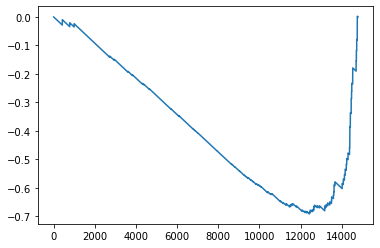

In [38]:
#hits, yvals = result_df.at[geneSet, 'hit_indices'], result_df.at[geneSet, 'RES']

geneSet = top[1]

hits = [i for i, x in enumerate(list(ranked[0])) if x in library_data[geneSet]]

abs_signature = np.array(np.abs(ranked.iloc[:,1]))
signature_map = {}
for i,h in enumerate(ranked[0]):
    signature_map[h] = i

yvals, es = blitz.enrichment_score(abs_signature, signature_map, library_data[geneSet])

In [39]:
#initialize figure basics
fig2 = make_subplots(rows=2, cols=1, row_heights = [0.8, 0.2],
        shared_xaxes=True, vertical_spacing = 0.10,
        subplot_titles=("Enrichment Plot", "Hit Indices"))

arbitrary = [dict(type="line", xref="x2", yref="y2", x0=0, y0=0,
            x1=len(rankedGenes), y1=0, line=dict(color="White", width=0.5)), 
            dict(type="line", xref="x2", yref="y2", x0=0, y0=-1,
            x1=0, y1=1, line=dict(color="White", width=0.5))]
            #pair of arbitrary lines that maintain scale of plot

fig2.update_layout(shapes=arbitrary, height=600, width=750, font_size=16)
buttons = [dict(label='All Top Gene Sets', method="update",
            args=[{"visible": [True for i in range(len(top))]}, {"shapes": arbitrary}])]

xvals = [i for i in range(len(rankedGenes))]
for geneSet in top:
    #plots values for each top gene set 
    #gets hit indices and running sum vector
    hits = [i for i, x in enumerate(list(ranked[0])) if x in library_data[geneSet]]
    abs_signature = np.array(np.abs(ranked.iloc[:,1]))
    signature_map = {}
    for i,h in enumerate(ranked[0]):
        signature_map[h] = i
    yvals, es = blitz.enrichment_score(abs_signature, signature_map, library_data[geneSet])

    index = top.index(geneSet)
    pval = top_result_df.at[geneSet, 'pval']
    #creates enrichment plot
    setName = lineBreak(geneSet)
    fig2.add_trace(go.Scatter(x=xvals, y=yvals, mode='lines', showlegend=True,
        name=setName, meta=[pval],
        text = ['Gene: {}'.format(gene) for gene in rankedGenes],
        hovertemplate=('%{text}' + 
        '<br>Ranking: %{x}' + 
        '<br>Running Sum: %{y}' +
        '<br>P-value: %{meta[0]}')),
        row=1, col=1)
    #creates hit indices
    lines = []
    for x in hits:
        line = dict(type="line", x0=x, y0=-1, x1=x, y1=1, xref = "x2", yref = "y2",
        line=dict(color="Blue", width=0.5))
        lines.append(line)
    #creates drop down menu option
    visible = [True if i==index else False for i in range(len(top))]
    button = dict(label=f'{geneSet}', method="update",
        args=[{"visible": visible}, {"shapes": lines}])
    buttons.append(button)

#make drop down menu
fig2.update_layout(updatemenus=[
    dict(buttons=buttons, pad = {"r": 10, "t": 10}, showactive = True,
    x = 0, xanchor = "left", y = 1.2, yanchor = "top")])
fig2.update_xaxes(title_text="Gene Rankings", row=2, col=1)
fig2.update_yaxes(title_text="Enrichment Score (ES)", row=1, col=1)
fig2.update_yaxes(visible=False, showticklabels=False, row=2, col=1)

fig2.show()

if pheno1 != None and pheno2 != None:
    display(HTML(f'<b><i>Figure 1: GSEA plot for the top {len(top)} gene sets in the {library_name} library. Those with a positive Enrichment Score and more hits on the left are correlated with {pheno1}, while those with a negative Enrichment Score and more hits on the right are correlated with {pheno2}.</i></b>'))
else:
    display(HTML(f'<b><i>Figure 1: GSEA plot for the top {len(top)} gene sets in the {library_name} library. Those with a positive Enrichment Score and more hits on the left are correlated with genes at the top of the ranked list, while those with a negative Enrichment Score and more hits on the right are correlated with genes at the bottom.</i></b>'))

In [57]:
def ledgeGenes(results):
    es, hit_indices, running_sum, signature  = results
    max_pos = np.argmax(np.abs(running_sum))
    ledge = []
    hits = []
    if es > 0:
        i = 0
        while max_pos >= hit_indices[i]:
            ledge.append(signature.at[hit_indices[i],0])
            hits.append(hit_indices[i])
            i += 1
    else:
        i = len(hit_indices)-1
        while max_pos <= hit_indices[i]:
            ledge.append(signature.at[hit_indices[i],0])
            hits.append(hit_indices[i])
            i -= 1
    if len(ledge) > 10:
        ledge = ledge[:10]
        hits = hits[:10]
    return {'genes': ledge, 'ranks': hits}

In [ ]:
%%appyter code_exec
{%- if library_tab.raw_value == 'Select an Enrichr Library' and augmentation.value == True %}
fig3 = make_subplots(rows=2, cols=1, row_heights = [0.8, 0.2],
        shared_xaxes=True, vertical_spacing = 0.10,
        subplot_titles=("Enrichment Plot", "Hit Indices"))
fig3.update_layout(shapes=arbitrary, height=600, width=750, font_size=16)
plot_buttons = [dict(label='All', method="update",
            args=[{"visible": [True for i in range(len(top*3))]}, {"shapes": arbitrary}])]
fig4 = go.Figure()
table_buttons = list()

for geneSet in top:
    #gets values to plot
    abs_signature = np.array(np.abs(ranked.iloc[:,1]))
    signature_map = {}
    for i,h in enumerate(ranked[0]):
        signature_map[h] = i
    
    yvals0, es0 = blitz.enrichment_score(abs_signature, signature_map, library_data[geneSet])
    hits0 = [i for i, x in enumerate(list(ranked[0])) if x in library_data[geneSet]]

    yvals1, es1 = blitz.enrichment_score(abs_signature, signature_map, augmented_data[geneSet])
    hits1 = [i for i, x in enumerate(list(ranked[0])) if x in augmented_data[geneSet]]

    yvals2, es2 = blitz.enrichment_score(abs_signature, signature_map, augmented_data[geneSet]+library_data[geneSet])
    hits2 = [i for i, x in enumerate(list(ranked[0])) if x in augmented_data[geneSet]+library_data[geneSet]]
    
    yvals = [yvals0, yvals1, yvals2]
    #gets top co-expressed genes
    #results = both[0], augmented[2], both[3]
    coexp = ledgeGenes((es, hits1, yvals0, ranked))
    coexp_df = pd.DataFrame.from_dict(data=coexp, orient='columns')
    fig4.add_trace(go.Table(columnwidth=[200, 200],
    header=dict(values=['Genes', 'Rank'], height=40), 
    cells=dict(values=[coexp_df.genes, coexp_df.ranks], height=30)))
    #plots the three random walks
    for i in range(len(yvals)):
        if i == 0:
            newName = geneSet + ' original'
        elif i == 1:
            newName = geneSet + ' augmented'
        elif i == 2:
            newName = geneSet + ' both'
        newName = lineBreak(newName)
        fig3.add_trace(go.Scatter(x=xvals, y=yvals[i], mode='lines', showlegend=True,
        name=newName, text = ['Gene: {}'.format(gene) for gene in rankedGenes],
        hovertemplate=('%{text}' + 
        '<br>Ranking: %{x}' + 
        '<br>Running Sum: %{y}')),
        row=1, col=1)
    #creates hit indices
    lines = []
    for x in hits0:
        line = dict(type='line', x0=x, y0=-1, x1=x, y1=1, xref = 'x2', yref = 'y2',
        line=dict(color="Blue", width=0.5))
        lines.append(line)
    for x in hits1:
        line = dict(type='line', x0=x, y0=-1, x1=x, y1=1, xref = 'x2', yref = 'y2',
        line=dict(color="Red", width=0.5))
        lines.append(line)
    #creates drop down menu option
    index = top.index(geneSet)
    plot_visible = [True if i >= index*3 and i < (index+1)*3 else False for i in range(len(top*3))]
    plot_button = dict(label=f'{geneSet}', method="update",
        args=[{"visible": plot_visible}, {"shapes": lines}])
    plot_buttons.append(plot_button)
    table_visible = [True if i == index else False for i in range(len(top))]
    table_button = dict(label=f'{geneSet}', method="update",
        args=[{"visible": table_visible}])
    table_buttons.append(table_button)

fig3.update_layout(updatemenus=[
    dict(buttons=plot_buttons, pad = {"r": 10, "t": 10}, showactive = True,
    x = 0, xanchor = "left", y = 1.2, yanchor = "top")])
fig3.update_xaxes(title_text="Gene Rankings", row=2, col=1)
fig3.update_yaxes(title_text="Enrichment Score (ES)", row=1, col=1)
fig3.update_yaxes(visible=False, showticklabels=False, row=2, col=1)
fig3.show()
display(HTML(f"<i><b>Figure 2: Random walk plots of augmented gene sets for the top {len(top)} gene sets in the {library_name} library. Each gene set has three plots: one with the original set, one with the augmented genes only, and one with them combined.</i></b>"))
{%- endif %}